# Free form visualization

In this notebook we will visualize how well the optimal model actually performed.

In [1]:
import matplotlib

from sklearn import neighbors
from sklearn.model_selection import train_test_split
from IPython.display import display

from data.get_50_highest_weights import get_sp_50_highest_weights_symbols
from data_preparation.ochlva_data import OCHLVAData
from utils.column_modifiers import target_generator
from utils.column_modifiers import feature_generator
from utils.column_modifiers import keep_columns
from utils.column_modifiers import reshift_targets
from estimators.predictions import calculate_rolling_prediction

C:\Users\michael.l.magnussen\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
matplotlib.use('nbAgg')

In [3]:
import matplotlib.pyplot as plt

Load the S&P 500 (as `^GSPC`) data

In [4]:
ochlva_data = OCHLVAData()

Load three other stocks: The stock weighted the most, the medium weighted stock and the lowest weighted stock (out of the 50 downloaded). 
We do this in order to get a better feeling of the model.

In [5]:
symbols = get_sp_50_highest_weights_symbols()

# Select symbols with high, medium and low weights
selected_symbols = (symbols.iloc[0], 
                    symbols.iloc[len(symbols)//2], 
                    symbols.iloc[-1])

for s in selected_symbols:
    ochlva_data.load_data(s)

For now, we will only be interested in training using the adjusted close values.

In [6]:
# Keep only 'Adj. Close' column
ochlva_data.transform(keep_columns, ['Adj. Close'], copy=False)

Next, we create the target values for the data.
The target columns will be shifted 7 days with respect to 'Adj. Close'.

In [7]:
days = [7]
ochlva_data.transform(target_generator, 'Adj. Close', days, copy=False)

## Make the predictions

<IPython.core.display.Javascript object>


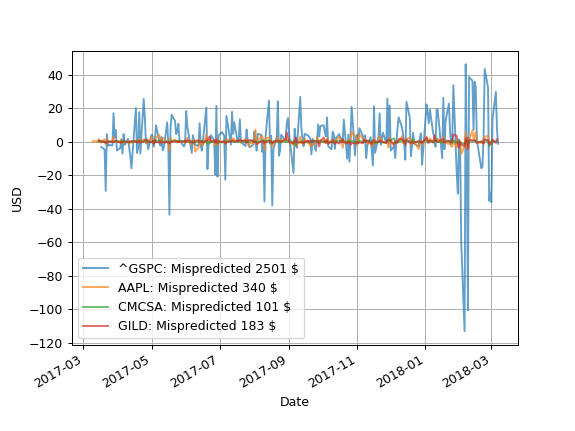

In [8]:
optimal_n = 1
feature_days = 160

ax = None
legends = list()

for key in ochlva_data.transformed_data.keys():
    
    x = ochlva_data.transformed_data[key].\
        loc[:, ochlva_data.transformed_data[key].columns[:-len(days)]] 
    y = ochlva_data.transformed_data[key].\
        loc[:, ochlva_data.transformed_data[key].columns[-len(days):]]
        
    x_w_features = feature_generator(x, 'Adj. Close', feature_days, copy=True)   
    
    x_train, x_test, y_train, y_test = \
        train_test_split(x_w_features, y, shuffle=False, test_size=.2)
    
    # Obtain the day of prediction
    # I.e. for a column named x + 2 days, we would expect the two last rows
    # to contain nan
    prediction_days = y_test.isnull().sum()
    
    # Make the regressor with the optimal n
    reg = neighbors.KNeighborsRegressor(n_neighbors=optimal_n)

    # NOTE: We refit the model here with the same architecture as we used in the
    #       predictions above
    #       However, the data will be different for each time as we do a rolling
    #       prediction
    y_pred = calculate_rolling_prediction(reg,
                                          x_train,
                                          x_test,
                                          y_train,
                                          y_test, 
                                          prediction_days)
    
    # Reshift the days so that they matches
    y_pred = reshift_targets(y_pred, x_test.index)
    # Rename the column in order to perform a proper subtraction between data
    # frames
    y_pred.columns = ['Adj. Close']
    
    diff = x_test.loc[:, ['Adj. Close']] - y_pred

    ax = diff.plot(ax = ax, alpha=0.7)
    
    legends.append(f'{key}: Mispredicted {diff.abs().sum().sum():.0f} $')

ax.legend(legends)
ax.grid()
_ = ax.set_ylabel('USD')
    
plt.show()